In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/Pneumonia FL/train/'
test_dir = '/content/drive/MyDrive/Pneumonia FL/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

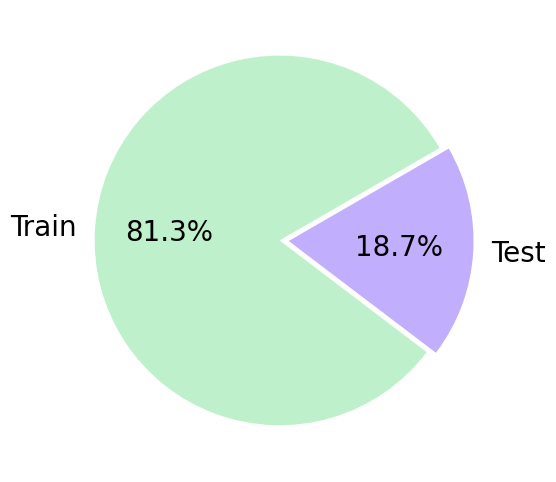

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [5]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

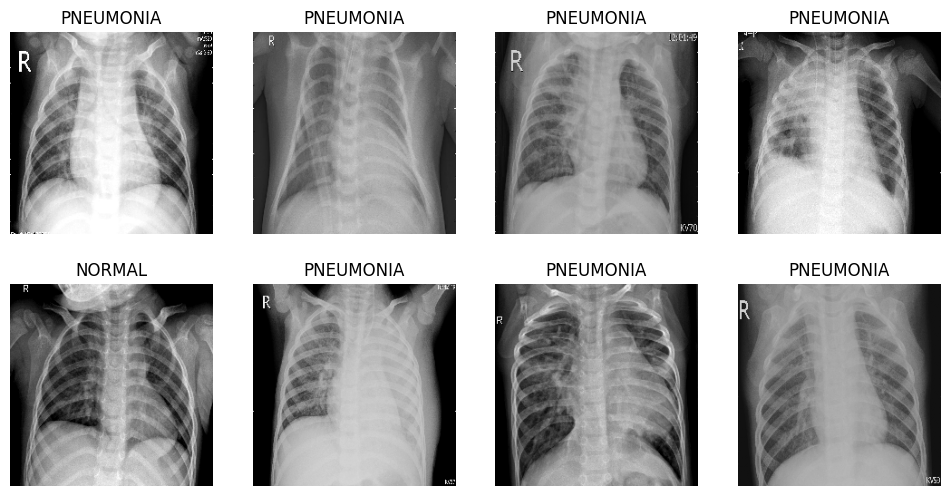

In [6]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [7]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [8]:
base_model = MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

17225924/17225924 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

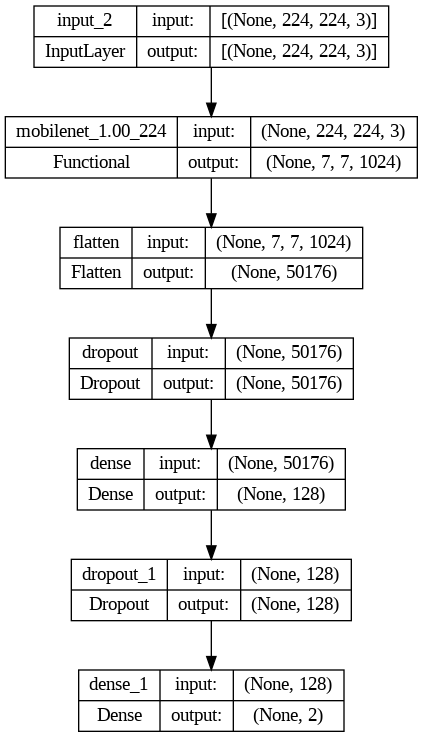

In [10]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [12]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 545s 2s/step - loss: 0.2294 - sparse_categorical_accuracy: 0.9376
Epoch 2/10
234/234 [==============================] - 297s 1s/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9743
Epoch 3/10
234/234 [==============================] - 297s 1s/step - loss: 0.0329 - sparse_categorical_accuracy: 0.9899
Epoch 4/10
234/234 [==============================] - 313s 1s/step - loss: 0.0291 - sparse_categorical_accuracy: 0.9886
Epoch 5/10
234/234 [==============================] - 298s 1s/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9942
Epoch 6/10
234/234 [==============================] - 306s 1s/step - loss: 0.0151 - sparse_categorical_accuracy: 0.9946
Epoch 7/10
234/234 [==============================] - 297s 1s/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9966
Epoch 8/10
234/234 [==============================] - 304s 1s/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9961
Epoch 9/10
234/234 [====================

# Federated Learning Based transfer Learning enabled MobileNet Model

In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
58/58 [==============================] - 144s 2s/step - loss: 0.0050 - sparse_categorical_accuracy: 0.9978
Epoch 2/5
58/58 [==============================] - 116s 2s/step - loss: 0.0016 - sparse_categorical_accuracy: 0.9995
Epoch 3/5
58/58 [==============================] - 118s 2s/step - loss: 3.4487e-05 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
58/58 [==============================] - 116s 2s/step - loss: 1.6804e-04 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
58/58 [==============================] - 117s 2s/step - loss: 0.0018 - sparse_categorical_accuracy: 0.9989
Epoch 1/5
58/58 [==============================] - 123s 2s/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9995
Epoch 2/5
58/58 [==============================] - 118s 2s/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9984
Epoch 3/5
58/58 [==============================] - 113s 2s/step - loss: 7.1924e-05 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
58/58 [==============================] - 1

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 1/36 [00:02<01:36,  2.76s/it]

1/1 [==============================] - 1s 1s/step


  6%|▌         | 2/36 [00:04<01:14,  2.18s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 3/36 [00:06<01:04,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 4/36 [00:08<01:02,  1.95s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 5/36 [00:09<00:58,  1.88s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 6/36 [00:11<00:57,  1.93s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 7/36 [00:14<01:02,  2.15s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 8/36 [00:17<01:07,  2.41s/it]

1/1 [==============================] - 1s 1s/step


 25%|██▌       | 9/36 [00:19<01:01,  2.29s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 10/36 [00:21<00:55,  2.12s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 11/36 [00:23<00:52,  2.11s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 12/36 [00:25<00:47,  1.99s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 13/36 [00:27<00:47,  2.06s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 14/36 [00:30<00:54,  2.46s/it]

1/1 [==============================] - 1s 1s/step


 42%|████▏     | 15/36 [00:33<00:50,  2.43s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 16/36 [00:34<00:44,  2.22s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 17/36 [00:36<00:39,  2.07s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 18/36 [00:38<00:35,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 19/36 [00:40<00:33,  1.98s/it]

1/1 [==============================] - 1s 1s/step


 56%|█████▌    | 20/36 [00:42<00:32,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 21/36 [00:45<00:36,  2.44s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 22/36 [00:48<00:33,  2.40s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 23/36 [00:50<00:29,  2.28s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 24/36 [00:51<00:25,  2.14s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 25/36 [00:53<00:22,  2.00s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 26/36 [00:56<00:23,  2.37s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 27/36 [01:00<00:24,  2.67s/it]

1/1 [==============================] - 1s 1s/step


 78%|███████▊  | 28/36 [01:01<00:19,  2.39s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 29/36 [01:03<00:15,  2.26s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 30/36 [01:05<00:13,  2.20s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 31/36 [01:07<00:10,  2.06s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 32/36 [01:09<00:08,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 33/36 [01:12<00:06,  2.31s/it]

1/1 [==============================] - 1s 1s/step


 94%|█████████▍| 34/36 [01:14<00:04,  2.26s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 35/36 [01:16<00:02,  2.15s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 36/36 [01:18<00:00,  2.01s/it]

1/1 [==============================] - 1s 646ms/step


37it [01:19,  2.15s/it]


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.97      0.94      0.96       317
   PNEUMONIA       0.98      0.99      0.98       855

    accuracy                           0.98      1172
   macro avg       0.98      0.97      0.97      1172
weighted avg       0.98      0.98      0.98      1172



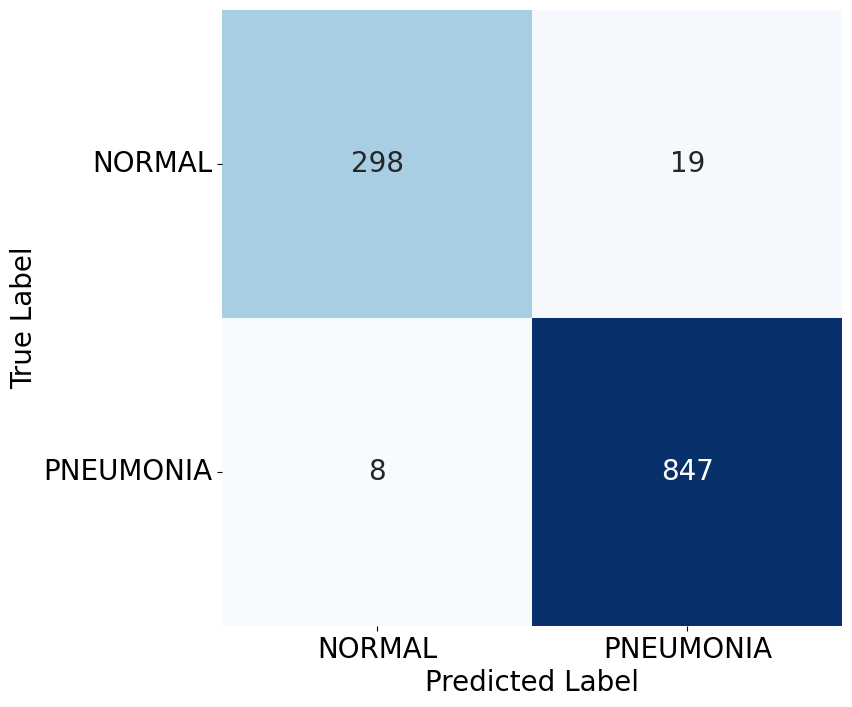

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



# Improved Code of Transfer Learning Based MobileNet Model

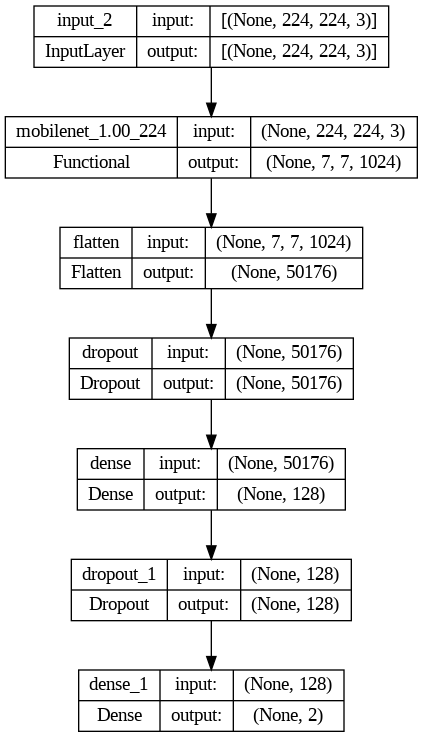

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [19]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 274s 1s/step - loss: 0.0111 - sparse_categorical_accuracy: 0.9976
Epoch 2/10
234/234 [==============================] - 287s 1s/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9936
Epoch 3/10
234/234 [==============================] - 293s 1s/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9944
Epoch 4/10
234/234 [==============================] - 294s 1s/step - loss: 0.0159 - sparse_categorical_accuracy: 0.9961
Epoch 5/10
234/234 [==============================] - 295s 1s/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9953
Epoch 6/10
234/234 [==============================] - 291s 1s/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9989
Epoch 7/10
234/234 [==============================] - 291s 1s/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9968
Epoch 8/10
234/234 [==============================] - 293s 1s/step - loss: 0.0195 - sparse_categorical_accuracy: 0.9953
Epoch 9/10
234/234 [====================

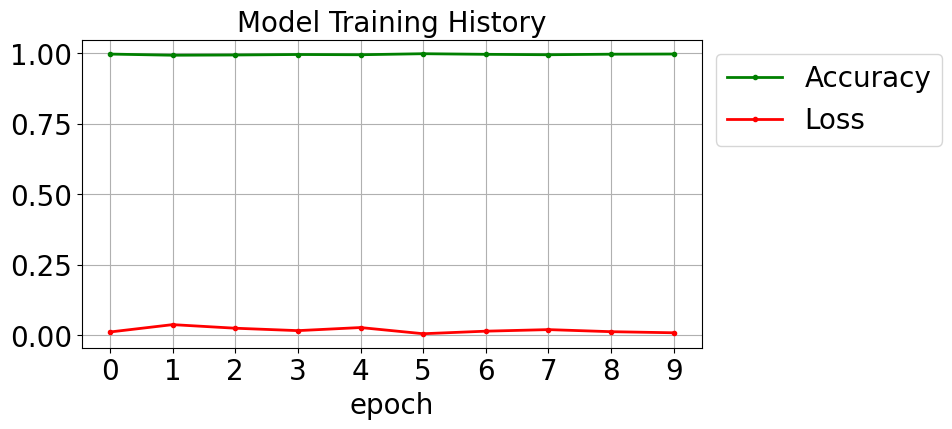

In [20]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [21]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 1/36 [00:02<01:40,  2.87s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 2/36 [00:05<01:39,  2.92s/it]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 3/36 [00:08<01:25,  2.58s/it]

1/1 [==============================] - 1s 1s/step


 11%|█         | 4/36 [00:09<01:13,  2.31s/it]

1/1 [==============================] - 1s 1s/step


 14%|█▍        | 5/36 [00:11<01:08,  2.20s/it]

1/1 [==============================] - 1s 1s/step


 17%|█▋        | 6/36 [00:13<01:04,  2.15s/it]

1/1 [==============================] - 1s 1s/step


 19%|█▉        | 7/36 [00:15<00:58,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 8/36 [00:18<01:06,  2.38s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 9/36 [00:21<01:05,  2.41s/it]

1/1 [==============================] - 1s 1s/step


 28%|██▊       | 10/36 [00:23<00:58,  2.26s/it]

1/1 [==============================] - 1s 1s/step


 31%|███       | 11/36 [00:25<00:53,  2.14s/it]

1/1 [==============================] - 1s 1s/step


 33%|███▎      | 12/36 [00:26<00:48,  2.03s/it]

1/1 [==============================] - 1s 1s/step


 36%|███▌      | 13/36 [00:28<00:47,  2.05s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 14/36 [00:31<00:45,  2.08s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 15/36 [00:34<00:50,  2.38s/it]

1/1 [==============================] - 1s 1s/step


 44%|████▍     | 16/36 [00:36<00:45,  2.30s/it]

1/1 [==============================] - 1s 1s/step


 47%|████▋     | 17/36 [00:38<00:41,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████     | 18/36 [00:40<00:37,  2.11s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 19/36 [00:43<00:41,  2.43s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 20/36 [00:46<00:42,  2.68s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 21/36 [00:49<00:41,  2.74s/it]

1/1 [==============================] - 1s 1s/step


 61%|██████    | 22/36 [00:51<00:35,  2.55s/it]

1/1 [==============================] - 1s 1s/step


 64%|██████▍   | 23/36 [00:53<00:30,  2.31s/it]

1/1 [==============================] - 1s 1s/step


 67%|██████▋   | 24/36 [00:55<00:26,  2.21s/it]

1/1 [==============================] - 1s 1s/step


 69%|██████▉   | 25/36 [00:57<00:23,  2.10s/it]

1/1 [==============================] - 1s 1s/step


 72%|███████▏  | 26/36 [00:59<00:20,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 27/36 [01:01<00:19,  2.17s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 28/36 [01:04<00:20,  2.53s/it]

1/1 [==============================] - 1s 1s/step


 81%|████████  | 29/36 [01:06<00:16,  2.33s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████▎ | 30/36 [01:08<00:13,  2.24s/it]

1/1 [==============================] - 1s 1s/step


 86%|████████▌ | 31/36 [01:10<00:10,  2.11s/it]

1/1 [==============================] - 1s 1s/step


 89%|████████▉ | 32/36 [01:13<00:09,  2.46s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 33/36 [01:17<00:08,  2.75s/it]

1/1 [==============================] - 3s 3s/step


 94%|█████████▍| 34/36 [01:20<00:05,  2.99s/it]

1/1 [==============================] - 1s 1s/step


 97%|█████████▋| 35/36 [01:22<00:02,  2.66s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 36/36 [01:26<00:00,  2.84s/it]

1/1 [==============================] - 1s 1s/step


37it [01:27,  2.37s/it]


In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.95      0.95      0.95       317
   PNEUMONIA       0.98      0.98      0.98       855

    accuracy                           0.97      1172
   macro avg       0.97      0.97      0.97      1172
weighted avg       0.97      0.97      0.97      1172



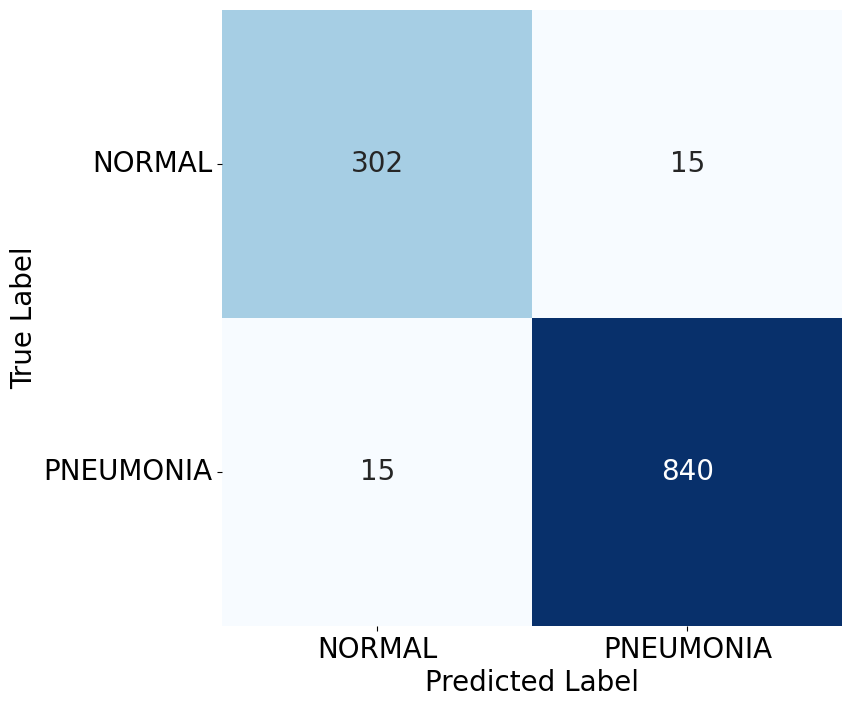

In [23]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Get the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()